In [3]:
import time
import os
import cv2

from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.file.TSV import RegionExporter
from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from lib.utilities import *
from lib.analysis.laminar_dist import *
from lib.analysis.grid_latency import *

####### GRID ROIS #######
# for each recording:
## 1) divide the entire frame of recording into grid of square n_sq x n_sq ROIs
## 2) write these grid square ROIs to file
## 3) take SNRs and latencies to .dat file of each ROI from PhotoZ
## filter out no-response grid squares by SNR cutoff (or manual inspection?)
## write out output file of (ROI center x, ROI center y, SNR, latency)
## analysis: directed graph analysis of latency, 3-D plot of latency, 3-D plot of SNR

In [4]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/"

n_sq = 5  # number of pixels of each square edge in the grid.
max_num_rois = 100  # SNR cutoff 

# sets of files in each slice directory -- naming convention
# input
corners_file_prefix_layer = 'corners_layer'  # defines axes of L4 boundaries
electrode_file_prefix = 'electrode'
# also needed: 01_01_01_snr.dat

# output files
rois_file_prefix = 'sq_rois' # e.g. 'sq_rois_01_to_09.dat'
rois_centers_filenames = "roi_centers.txt"

image_data = {}
n_plots = 5000  # show up to how many plots

disable_photoZ_interact = True
initialize_photoZ = False
rewrite_data_files = False

In [5]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and not disable_photoZ_interact:
    aPhz.prepare_photoZ()

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_01
slice 2 , rec 1
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_01/corners_layer.dat
edge_pts [[8, 69], [37, 71]] axis_pts [[44, 10], [77, 17]]
laminar axis unit vectors: [-0.5208646456291304, 0.8536392803366304] [-0.5952275506257376, 0.8035571933447457]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_01//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_01/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_01/corners_layer_laminar_distances.txt


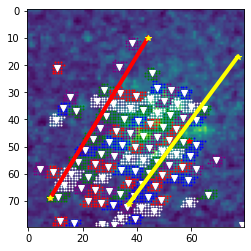

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_03
slice 2 , rec 3
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_03/corners_layer.dat
edge_pts [[8, 69], [37, 71]] axis_pts [[44, 10], [77, 17]]
laminar axis unit vectors: [-0.5208646456291304, 0.8536392803366304] [-0.5952275506257376, 0.8035571933447457]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_03//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_03/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_03/corners_layer_laminar_distances.txt


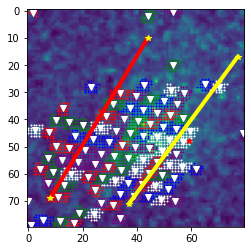

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_02_02
slice 2 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_02_02/corners_layer.dat
edge_pts [[39, 70], [8, 68]] axis_pts [[72, 15], [44, 10]]
laminar axis unit vectors: [-0.5144957554275266, 0.8574929257125442] [-0.5273628617781428, 0.8496401661981191]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_02_02//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_02_02/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_02_02/corners_layer_laminar_distances.txt


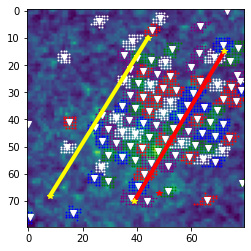

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_01_01
slice 3 , rec 1
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_01_01/corners_layer.dat
edge_pts [[18, 69], [48, 72]] axis_pts [[26, 9], [56, 11]]
laminar axis unit vectors: [-0.13216372009101796, 0.9912279006826347] [-0.13003403680018621, 0.9915095306014198]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_01_01//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_01_01/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_01_01/corners_layer_laminar_distances.txt


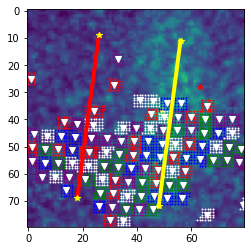

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_01
slice 3 , rec 1
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_01/corners_layer.dat
edge_pts [[18, 70], [53, 72]] axis_pts [[23, 8], [52, 11]]
laminar axis unit vectors: [-0.08038418992031009, 0.996763955011845] [0.01639124023930107, 0.9998656545973652]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_01//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_01/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_01/corners_layer_laminar_distances.txt


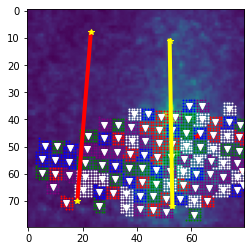

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_02
slice 3 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_02/corners_layer.dat
edge_pts [[18, 70], [53, 72]] axis_pts [[23, 8], [52, 11]]
laminar axis unit vectors: [-0.08038418992031009, 0.996763955011845] [0.01639124023930107, 0.9998656545973652]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_02//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_02/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_02/corners_layer_laminar_distances.txt


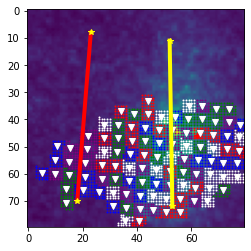

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_12
slice 3 , rec 12
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_12/corners_layer.dat
edge_pts [[18, 70], [53, 72]] axis_pts [[23, 8], [52, 11]]
laminar axis unit vectors: [-0.08038418992031009, 0.996763955011845] [0.01639124023930107, 0.9998656545973652]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_12//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_12/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_12/corners_layer_laminar_distances.txt


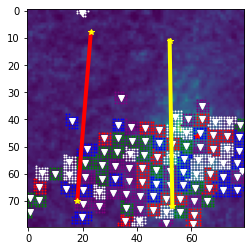

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_01
slice 6 , rec 1
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_01/corners_layer.dat
edge_pts [[4, 65], [41, 72]] axis_pts [[59, 12], [75, 35]]
laminar axis unit vectors: [-0.7200778916462509, 0.6938932410409328] [-0.6766252893427926, 0.736327520755392]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_01//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_01/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_01/corners_layer_laminar_distances.txt


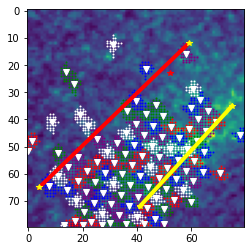

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_03
slice 6 , rec 3
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_03/corners_layer.dat
edge_pts [[4, 65], [41, 72]] axis_pts [[59, 12], [75, 35]]
laminar axis unit vectors: [-0.7200778916462509, 0.6938932410409328] [-0.6766252893427926, 0.736327520755392]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_03//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_03/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_03/corners_layer_laminar_distances.txt


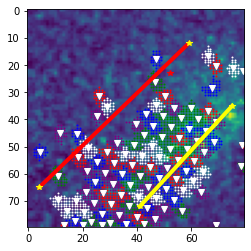

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_06
slice 6 , rec 6
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_06/corners_layer.dat
edge_pts [[4, 65], [41, 72]] axis_pts [[59, 12], [75, 35]]
laminar axis unit vectors: [-0.7200778916462509, 0.6938932410409328] [-0.6766252893427926, 0.736327520755392]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_06//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_06/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_06/corners_layer_laminar_distances.txt


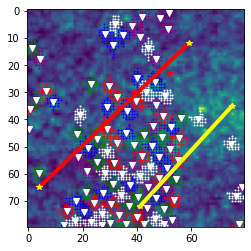

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_01_07
slice 1 , rec 7
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_01_07/corners_layer.dat
edge_pts [[5, 45], [32, 70]] axis_pts [[62, 13], [74, 37]]
laminar axis unit vectors: [-0.8719837853854813, 0.4895347567076386] [-0.7863183388224226, 0.6178215519319035]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_01_07//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_01_07/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_01_07/corners_layer_laminar_distances.txt


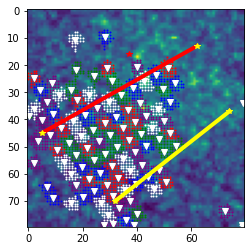

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_02_05
slice 1 , rec 5
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_02_05/corners_layer.dat
edge_pts [[6, 41], [30, 71]] axis_pts [[60, 11], [74, 36]]
laminar axis unit vectors: [-0.8741572761215377, 0.48564293117863205] [-0.7826010541756486, 0.6225235658215387]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_02_05//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_02_05/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_02_05/corners_layer_laminar_distances.txt


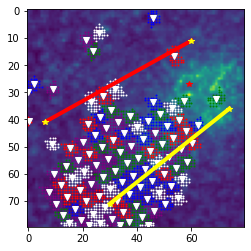

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_03
slice 1 , rec 3
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_03/corners_layer.dat
edge_pts [[6, 35], [26, 70]] axis_pts [[57, 10], [76, 36]]
laminar axis unit vectors: [-0.8979207227269799, 0.44015721702302935] [-0.8269265020695281, 0.5623100214072791]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_03//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_03/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_03/corners_layer_laminar_distances.txt


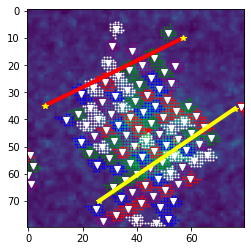

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_04
slice 1 , rec 4
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_04/corners_layer.dat
edge_pts [[6, 35], [26, 70]] axis_pts [[57, 10], [76, 36]]
laminar axis unit vectors: [-0.8979207227269799, 0.44015721702302935] [-0.8269265020695281, 0.5623100214072791]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_04//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_04/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_04/corners_layer_laminar_distances.txt


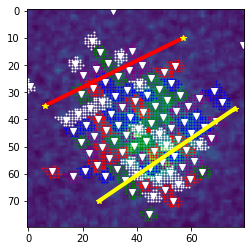

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_04_02
slice 1 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_04_02/corners_layer.dat
edge_pts [[7, 38], [32, 70]] axis_pts [[49, 11], [73, 35]]
laminar axis unit vectors: [-0.8411784753765535, 0.5407575913134988] [-0.7605645022019074, 0.6492623799284576]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_04_02//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_04_02/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_04_02/corners_layer_laminar_distances.txt


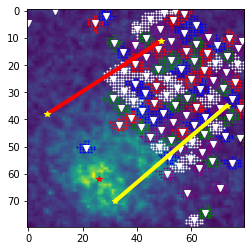

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_05_05
slice 1 , rec 5
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_05_05/corners_layer.dat
edge_pts [[6, 39], [34, 67]] axis_pts [[48, 11], [75, 38]]
laminar axis unit vectors: [-0.8320502943378437, 0.5547001962252291] [-0.8164156395068652, 0.5774647206268071]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_05_05//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_05_05/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_05_05/corners_layer_laminar_distances.txt


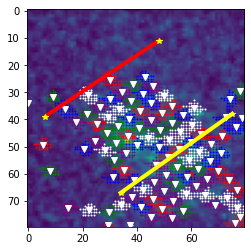

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_02
slice 2 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_02/corners_layer.dat
edge_pts [[78, 26], [75, 60]] axis_pts [[13, 8], [9, 47]]
laminar axis unit vectors: [0.9637300218770024, 0.26687908298132373] [0.9811482730462595, 0.19325647802426324]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_02//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_02/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_02/corners_layer_laminar_distances.txt


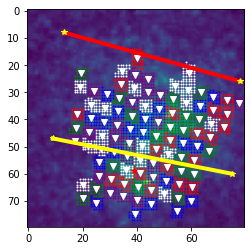

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_04
slice 2 , rec 4
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_04/corners_layer.dat
edge_pts [[78, 26], [75, 60]] axis_pts [[13, 8], [9, 47]]
laminar axis unit vectors: [0.9637300218770024, 0.26687908298132373] [0.9811482730462595, 0.19325647802426324]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_04//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_04/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_04/corners_layer_laminar_distances.txt


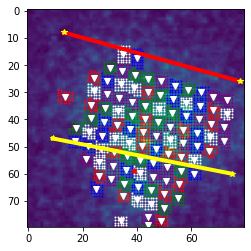

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_02_02
slice 2 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_02_02/corners_layer.dat
edge_pts [[12, 14], [5, 48]] axis_pts [[73, 26], [70, 60]]
laminar axis unit vectors: [-0.981194456491118, -0.19302186029333468] [-0.9833821803872266, -0.18154747945610336]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_02_02//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_02_02/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_02_02/corners_layer_laminar_distances.txt


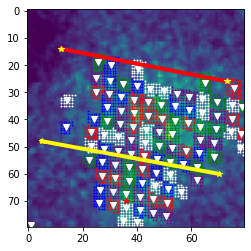

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_05
slice 2 , rec 5
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_05/corners_layer.dat
edge_pts [[8, 17], [7, 52]] axis_pts [[74, 30], [70, 59]]
laminar axis unit vectors: [-0.9811482730462595, -0.19325647802426324] [-0.9938837346736189, -0.11043152607484655]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_05//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_05/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_05/corners_layer_laminar_distances.txt


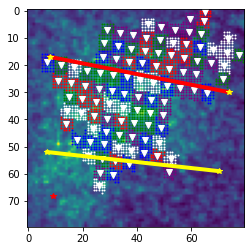

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_08
slice 2 , rec 8
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_08/corners_layer.dat
edge_pts [[8, 17], [7, 52]] axis_pts [[74, 30], [70, 59]]
laminar axis unit vectors: [-0.9811482730462595, -0.19325647802426324] [-0.9938837346736189, -0.11043152607484655]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_08//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_08/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_08/corners_layer_laminar_distances.txt


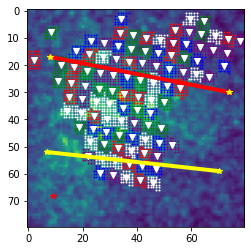

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_01
slice 2 , rec 1
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_01/corners_layer.dat
edge_pts [[75, 57], [52, 72]] axis_pts [[16, 9], [8, 34]]
laminar axis unit vectors: [0.7757116786991037, 0.63108746741622] [0.7568230077691596, 0.6536198703460924]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_01//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_01/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_01/corners_layer_laminar_distances.txt


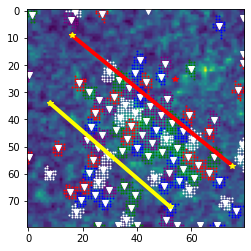

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_04
slice 2 , rec 4
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_04/corners_layer.dat
edge_pts [[75, 57], [52, 72]] axis_pts [[16, 9], [8, 34]]
laminar axis unit vectors: [0.7757116786991037, 0.63108746741622] [0.7568230077691596, 0.6536198703460924]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_04//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_04/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_04/corners_layer_laminar_distances.txt


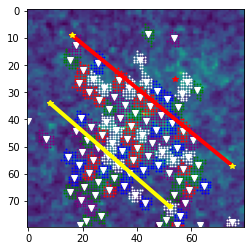

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_06
slice 2 , rec 6
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_06/corners_layer.dat
edge_pts [[75, 57], [52, 72]] axis_pts [[16, 9], [8, 34]]
laminar axis unit vectors: [0.7757116786991037, 0.63108746741622] [0.7568230077691596, 0.6536198703460924]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_06//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_06/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_06/corners_layer_laminar_distances.txt


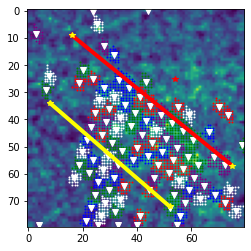

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_02_03
slice 2 , rec 3
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_02_03/corners_layer.dat
edge_pts [[75, 60], [48, 72]] axis_pts [[18, 8], [8, 31]]
laminar axis unit vectors: [0.738766024783967, 0.6739619875222155] [0.6983238520753277, 0.7157819483772108]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_02_03//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_02_03/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_02_03/corners_layer_laminar_distances.txt


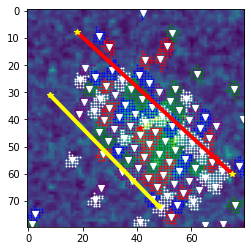

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_03_02
slice 2 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_03_02/corners_layer.dat
edge_pts [[73, 59], [42, 71]] axis_pts [[19, 8], [9, 33]]
laminar axis unit vectors: [0.7270131525498175, 0.6866235329637166] [0.655686655446243, 0.7550331183926435]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_03_02//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_03_02/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_03_02/corners_layer_laminar_distances.txt


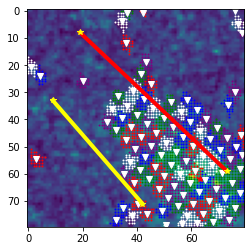

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_04_02
slice 2 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_04_02/corners_layer.dat
edge_pts [[75, 67], [52, 73]] axis_pts [[14, 7], [7, 33]]
laminar axis unit vectors: [0.7129262923855025, 0.7012389761168877] [0.7474093186836598, 0.6643638388299198]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_04_02//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_04_02/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_04_02/corners_layer_laminar_distances.txt


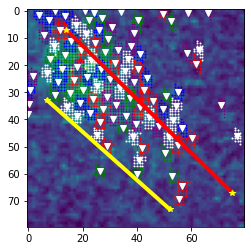

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_01
slice 2 , rec 1
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_01/corners_layer.dat
edge_pts [[75, 60], [49, 72]] axis_pts [[25, 8], [7, 29]]
laminar axis unit vectors: [0.6931087162517846, 0.720833064901856] [0.6987395238751688, 0.7153761792055299]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_01//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_01/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_01/corners_layer_laminar_distances.txt


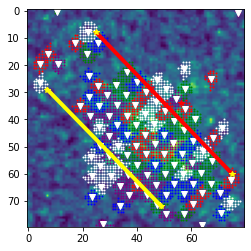

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_05
slice 2 , rec 5
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_05/corners_layer.dat
edge_pts [[75, 60], [49, 72]] axis_pts [[25, 8], [7, 29]]
laminar axis unit vectors: [0.6931087162517846, 0.720833064901856] [0.6987395238751688, 0.7153761792055299]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_05//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_05/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_05/corners_layer_laminar_distances.txt


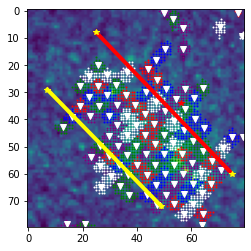

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_06
slice 2 , rec 6
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_06/corners_layer.dat
edge_pts [[75, 60], [49, 72]] axis_pts [[25, 8], [7, 29]]
laminar axis unit vectors: [0.6931087162517846, 0.720833064901856] [0.6987395238751688, 0.7153761792055299]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_06//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_06/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_06/corners_layer_laminar_distances.txt


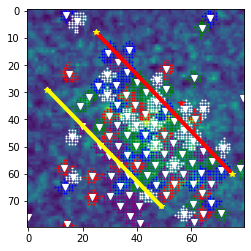

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_03
slice 3 , rec 3
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_03/corners_layer.dat
edge_pts [[76, 32], [73, 61]] axis_pts [[8, 31], [8, 60]]
laminar axis unit vectors: [0.9998918860475786, 0.014704292441876156] [0.999881677808259, 0.015382795043203983]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_03//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_03/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_03/corners_layer_laminar_distances.txt


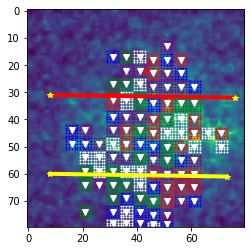

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_05
slice 3 , rec 5
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_05/corners_layer.dat
edge_pts [[76, 32], [73, 61]] axis_pts [[8, 31], [8, 60]]
laminar axis unit vectors: [0.9998918860475786, 0.014704292441876156] [0.999881677808259, 0.015382795043203983]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_05//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_05/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_05/corners_layer_laminar_distances.txt


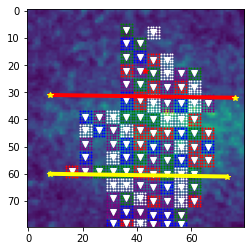

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_08
slice 3 , rec 8
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_08/corners_layer.dat
edge_pts [[76, 32], [73, 61]] axis_pts [[8, 31], [8, 60]]
laminar axis unit vectors: [0.9998918860475786, 0.014704292441876156] [0.999881677808259, 0.015382795043203983]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_08//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_08/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_08/corners_layer_laminar_distances.txt


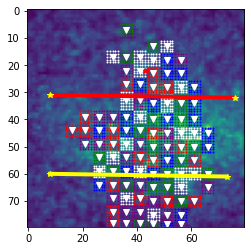

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_02
slice 3 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_02/corners_layer.dat
edge_pts [[75, 44], [75, 68]] axis_pts [[8, 36], [7, 63]]
laminar axis unit vectors: [0.9929467931694284, 0.11856081112470786] [0.9973076252903365, 0.07333144303605414]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_02//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_02/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_02/corners_layer_laminar_distances.txt


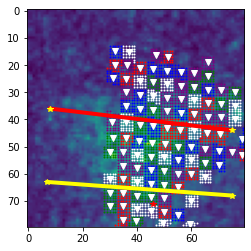

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_06
slice 3 , rec 6
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_06/corners_layer.dat
edge_pts [[75, 44], [75, 68]] axis_pts [[8, 36], [7, 63]]
laminar axis unit vectors: [0.9929467931694284, 0.11856081112470786] [0.9973076252903365, 0.07333144303605414]
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_06//roi_centers.txt
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_06/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_06/corners_layer_laminar_distances.txt


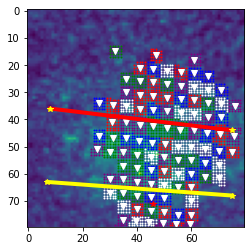

	slice directory count: 35
	missing_la_file_count: 0


In [6]:
slice_count = 0
missing_la_file_count = 0
for subdir, dirs, files in os.walk(data_dir):
    if 'notUsable' in subdir:
        continue
    if 'selected_zda' not in subdir:
        continue
    print(subdir)
    subdir += '/'
    for filename in files:
        fn = filename.split(".")[0]
        if (fn.endswith("_snr") or fn.startswith("SNR")) and "roi" not in fn:
            name_parse = filename[:8]  # of the format 07-01-01
            if fn.startswith("SNR"):
                name_parse = filename[4:11]
            try:
                sep = "_"
                if "-" in name_parse:
                    sep = "-"
                slic, loc, rec = [int(x) for x in name_parse.split(sep)]
            except ValueError:
                print("Could not parse:", name_parse)
                continue
            if slic not in image_data:
                image_data[slic] = {}
            if loc not in image_data[slic]:
                image_data[slic][loc] = {}
            if rec not in image_data[slic][loc]:
                image_data[slic][loc][rec] = {}
            if subdir not in image_data[slic][loc][rec]:
                image_data[slic][loc][rec][subdir] = {}
                
            snr = np.loadtxt(subdir + filename,
                             delimiter='\t',
                             usecols=(1,))
            width = int(np.sqrt(snr.shape[0]))
            snr = snr.reshape((width, width))
            n_grid_size = int(width / n_sq)  # how many squares will fit along frame edge
            image_data[slic][loc][rec][subdir]['snr_map'] = snr
            print("slice", slic, ", rec", rec)

            # corners file: 2 points p1, p2 to define the edge along which to measure
            la_file = subdir + corners_file_prefix_layer + '.dat'
            lines = None
            if not os.path.exists(la_file):
                missing_la_file_count += 1
            else:
                print("Processing", la_file)
                slice_count += 1
                with open(la_file, 'r') as f:
                    lines = f.readlines() 
                corners = [int(x) for x in lines[4:]] # the last 4 lines are diode numbers of corners
                layer_axes = LayerAxes(corners)
                laminar_axis, laminar_axis_2 = layer_axes.get_layer_axes()
                print("laminar axis unit vectors:", laminar_axis.get_unit_vector(), 
                      laminar_axis_2.get_unit_vector())

                # make our own square ROIs aligned to the list of edges and write them to a .dat file
                ################################
                # Limit # of ROIs by SNR to n highest SNR ROIs so that we can do
                #        smaller ROIs without exceeding 100-ROI-per-file cap
                ################################
                roi_cr = SquareROICreator(layer_axes, roi_width=n_sq, max_num_rois=max_num_rois, snr=snr)
                rois = roi_cr.get_rois()  # list of LaminarROI objects
                roi_centers = roi_cr.get_roi_centers(rounded=True) 
                # print("ROI centers:", roi_centers)
                roi_cr.write_roi_centers_to_file(subdir + "/" + rois_centers_filenames)

                # write these ROIs to file
                roi_fn = roi_cr.write_roi_file(subdir, rois_file_prefix)
                print("Created file:", roi_fn)

                # open stim point roi as a single integer (its diode number) in variable stim_pt
                sp_file = subdir + electrode_file_prefix + '.dat'
                with open(sp_file, 'r') as f:
                    lines = f.readlines()
                stim_pt = int(lines[-1]) # last line is always electrode location
                aux_obj = LaminarROI([stim_pt]).get_points()
                stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
                #print("Stim point:", stim_pt)

                # run laminar dist computation
                laminar_distances_obj = LaminarDistance(laminar_axis, rois, stim_pt)
                laminar_distances = laminar_distances_obj.compute_laminar_distances()
                laminar_distances = [round(ld, 2) for ld in laminar_distances]
                #print('laminar_distances:', laminar_distances)  # a list of integers with same indexing as rois

                # run laminar dist again with the other axis
                laminar_distances_2 = LaminarDistance(laminar_axis_2, rois, stim_pt).compute_laminar_distances()
                laminar_distances_2 = [round(ld, 2) for ld in laminar_distances_2]
                #print('laminar_distances 2:', laminar_distances_2)  # a list of integers with same indexing as rois

                # write averaged laminar distances to file
                avg_laminar_distances = [round(
                    (laminar_distances[i] + laminar_distances_2[i]) / 2,
                    2)
                                        for i in range(len(laminar_distances))]
                #print('laminar_distances averaged :', avg_laminar_distances) 
                ld_filename_base = la_file[:-4] + "_"
                laminar_distances_obj.write_laminar_distance_file(ld_filename_base, avg_laminar_distances)
                
                #image_data[slic][loc][rec][subdir] = {
                #    'snr': snr,
                #    'filename': filename}

                # Now that the data is stored, show intermediate computations in plot
                if n_plots > 0:
                    lines = [laminar_axis.get_line_repr(),
                             laminar_axis_2.get_line_repr()]
                    line_colors = ['red', 'yellow']
                    linewidths = [4,4]
                    other_colors = ['red', 'green', 'blue', 'white', 'purple']
                    roi_colors = []

                    # laminar aux lines
                    uv = laminar_axis.get_unit_vector()
                    for i in range(len(laminar_distances)):
                        ld = laminar_distances[i]
                        jiggle = i - int(len(laminar_distances) / 2)
                        uv_perp = Line(laminar_axis.get_start_point(), 
                                       laminar_axis_2.get_start_point()).get_unit_vector()
                        stim_proxy_pt = [stim_pt[0] - jiggle * uv_perp[0], 
                                         stim_pt[1] - jiggle * uv_perp[1]]
                        measure_vector = [uv[0] * ld + stim_proxy_pt[0], uv[1] * ld + stim_proxy_pt[1]]
                        lines.append([measure_vector, stim_proxy_pt])
                        this_color = other_colors[i % len(other_colors)]
                        line_colors.append(this_color)
                        roi_colors.append(this_color)
                        linewidths.append(1)

                    GridVisualization(snr, stim_pt, roi_centers, layer_axes.get_corners(),
                                      lines, line_colors, linewidths,
                                      rois, roi_colors,
                                      save_dir=subdir+"GridVisual1"+name_parse+'.png')
                    n_plots -= 1

print("\tslice directory count:", slice_count)
print("\tmissing_la_file_count:", missing_la_file_count)

In [7]:
## 3) take SNRs and latencies to .dat file of each ROI from PhotoZ
slice_count = 0
missing_roi_file_count = 0
if not disable_photoZ_interact:
    for subdir, dirs, files in os.walk(data_dir):
        if 'notUsable' in subdir:
            continue
        if 'selected_zda' not in subdir:
            continue

        for zda_file in files:
            if zda_file.endswith('.zda'):
                rec_id = zda_file.split('.')[0]
                slic_id, loc_id, _ = [int(x) for x in rec_id.split("_")]
                print(rec_id)
                
                # check for existing files
                filename_end = "_rois_" + rec_id + ".dat"
                snr_filename = subdir + "/" + "snr_" + filename_end
                latency_filename = subdir + "/" + "latency_" + filename_end                
                need_to_open_zda = rewrite_data_files or ((not os.path.isfile(snr_filename)) 
                                        or (not os.path.isfile(latency_filename)))
                slice_count += 1
                
                if need_to_open_zda:
                    
                    roi_fn = rois_file_prefix + ".dat"
                    if roi_fn not in files:
                        print("\t", subdir, "has no file named", rois_file_prefix + ".dat") 
                        missing_roi_file_count += 1
                        continue
                    roi_fn = subdir + "/" + roi_fn
                    
                    # open this zda file in photoZ
                    aPhz = AutoPhotoZ(data_dir=subdir)
                    aPhz.select_PhotoZ()

                    print("\n\nOpening", zda_file)
                    aPhz.open_zda_file(subdir + "/" + zda_file)

                    # open ROI file
                    aPhz.select_roi_tab()
                    aPhz.open_roi_file(roi_fn)

                    # save SNR values
                    aPhz.select_SNR_trace_value()
                    aPhz.save_trace_values(snr_filename)

                    # save latency values
                    aPhz.select_latency_trace_value()
                    aPhz.save_trace_values(latency_filename)

                else:
                    print("snr_" + filename_end, "and", "latency_" + filename_end, "already exist in", subdir)

print("\tslice directory count:", slice_count)
print("\tmissing_roi_file_count:", missing_roi_file_count)

	slice directory count: 0
	missing_roi_file_count: 0


In [8]:
## filter out no-response grid squares by SNR cutoff (or manual inspection?)
###   Read in the SNR/latency files/roi center files
slice_count = 0
for slic in image_data:
    for loc in image_data[slic]:
        for rec in image_data[slic][loc]:
            for subdir in image_data[slic][loc][rec]:
                slice_count += 1
                def pad_z2(x):
                    x = str(x)
                    while len(x) < 2:
                        x = '0' + x
                    return x
                
                rec_id = pad_z2(slic) + "_" + pad_z2(loc) + "_" + pad_z2(rec)
                
                filename_end = "_rois_" + rec_id + ".dat"
                snr_filename = subdir + "/" + "SNR_" + filename_end
                latency_filename = subdir + "/" + "latency_" + filename_end 
                roi_center_filename = subdir + "/" + rois_centers_filenames


                snr_df = pd.read_csv(snr_filename, sep='\t', header=None,
                                     names=['Index',  'SNR'])
                latency_df = pd.read_csv(latency_filename, sep='\t', header=None,
                                     names=['ROI Index',  'Latency'])
                roi_center_df = pd.read_csv(roi_center_filename, sep='\t', header=None,
                                     names=['Center x',  'Center y'])
                
                combined_df = roi_center_df.join(latency_df)
                combined_df = combined_df.join(snr_df[['SNR']])
                print(rec_id, combined_df)
                
                
                ############## Analysis: ############################
                ##### 1) directed graph analysis of latency #########
                ##### 2) 3-D plot of latency ########################
                ##### 3) 3-D plot of SNR ############################
                #####################################################
                
                
                # 1) directed graph analysis of latency
                nd_list = [Node([row[['Center x']], row[['Center y']]],
                                 row[['Latency']],
                                 row[['SNR']]) for _, row in combined_df.iterrows()]
                grid = Grid(nd_list, n_sq, latency_tolerance=0.2)
                
                ## a) determine latency ordering on directed graph
                grid.populate_latency_matrix()
                
                ## b) visualize
                snr_map = None
                try:
                    snr_map = image_data[slic][loc][rec][subdir]['snr_map']
                except Exception as e:
                    snr_map = np.zeros((80, 80))  # default
                grid.visualize_spatial_flow(snr_map=snr_map,
                                           )
                save_dir=subdir+"GridVisual1"+name_parse+'.png'
                
                
                break
            break
        break
    break
                
                
print("\tslice directory count:", slice_count) 

02_01_01     Center x  Center y  ROI Index  Latency       SNR
0      44.83     41.67          1  51.1183   9.61539
1      42.17     45.96          2  51.2150  17.13350
2      40.23     40.55          3  51.2024   8.93203
3      47.27     37.45          4  51.0467  12.23910
4      47.23     46.55          5  50.7590  11.20570
..       ...       ...        ...      ...       ...
95     21.91     70.09         96  54.3827   3.18976
96     45.43     23.09         97  51.1012   3.62933
97     16.67     78.00         98  53.4094   2.04289
98     15.56     60.03         99  46.1982   2.37329
99      4.38     58.38        100  47.5722   1.59600

[100 rows x 5 columns]
<lib.analysis.grid_latency.Node object at 0x0000017B788FABB0> <lib.analysis.grid_latency.Node object at 0x0000017B788FAD60> Center x    False
Center y    False
dtype: bool


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().